# Regressing TESS rotation periods with CNNs

TESS systematics make it difficult to measure long (> 13 day) rotation periods from TESS light curves using conventional frequency analysis. In this tutorial we will use a Convolutional Neural Network (CNN) to regress periods from TESS light curve transforms.

## Introduction
The goal of this notebook is to use [SMARTS](https://archive.stsci.edu/hlsp/smarts) data with the open-source CNN code [`smartsnn`](https://github.com/zclaytor/smartsnn) to regress TESS rotation periods. We will
1. Read in a subset of the training data,
2. Define training, validation, and evaluation functions,
3. Train the CNN on SMARTS data,
4. Predict rotation periods using SMARTS test data, and
5. Compare the predicted periods to the true simulation periods.

The training examples are 2-dimensional arrays of wavelet transforms of TESS light curves. The wavelet transform concentrates the periodicity of the light curve, making it easier for a CNN to regress the period. CNNs take advantage of the image-like nature of a wavelet transform in the same way that CNNs are useful for image recognition and computer vision.

## Installs and Imports
This notebook uses the following packages:
- `smartsnn` for building and using the CNN
- `glob` for generating lists of training files
- `copy` for saving training weights
- `numpy` for array operations
- `astropy` for reading FITS files
- `torch` for tensor and CNN operations

`smartsnn` is on [GitHub](https://github.com/zclaytor/smartsnn); we install it first. The other packages can be installed using `pip` or `conda`.

We will also need to download and uncompress the training data from MAST. Let's do that first.

In [1]:
# Download training data
!curl -o hlsp_smarts_tess_ffi_all_tess_v1.0_cat.tar.gz https://archive.stsci.edu/hlsps/smarts/hlsp_smarts_tess_ffi_all_tess_v1.0_cat.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1873M  100 1873M    0     0   101M      0  0:00:18  0:00:18 --:--:-- 85.6M


In [2]:
# Extract training data
!tar -xvzf hlsp_smarts_tess_ffi_all_tess_v1.0_cat.tar.gz

hlsp_smarts_tess_ffi_all_tess_v1.0_sim.fits


In [3]:
# Install needed packages
%pip install torch --index-url https://download.pytorch.org/whl/cpu
%pip install git+https://github.com/zclaytor/smartsnn

Looking in indexes: https://download.pytorch.org/whl/cpu
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/zclaytor/smartsnn to /tmp/pip-req-build-bfhko33v
  Running command git clone --filter=blob:none --quiet https://github.com/zclaytor/smartsnn /tmp/pip-req-build-bfhko33v
  Resolved https://github.com/zclaytor/smartsnn to commit 154b574945aea7eb53e61316869bd7daa24caa58
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [4]:
from glob import glob # for generating lists of input files
from copy import deepcopy # for saving CNN weights

import numpy as np # array operations
from astropy.io import fits # FITS file operations

# For tensor and CNN operations
import torch 
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader

# For defining and training the CNN
from smartsnn.model import ConvNet
from smartsnn.model import Laplacian_NLL as loss_function

## 1. Define training data loader
We use Pytorch `Dataset` (subclassed here) and `DataLoader` (used below) to load the wavelet data. Pytorch `Dataset` and `DataLoader` can be accessed in chunks, which makes training more efficient.

In [5]:
class WaveletDataset(Dataset):
    """
    WaveletDataset to read in the training data.

    Attributes
    ----------
    `wavelets`: array containing the stack of wavelet transforms.

    `periods`: array of rotation period corresponding to each wavelet transform.
    """

    def __init__(self, periods, wavelets, mode, random_seed=42, max_n=10000, split=(8, 1, 1), normalize=True):
        """
        Parameters
        ----------
        `periods` (numpy.ndarray): the array of rotation periods, or labels.

        `wavelets` (numpy.ndarray): the array of wavelet power spectra, or features.

        `mode` (str): must be one of "train", "val", or "test". Loads different data
            depending on the specified mode.

        `random_seed` (int, optional): seed for random number generator for 
            reproducibility.

        `max_n` (int, optional): the number of training examples to use.

        `split` (list-like): the split fractions for train/validation/test partitions

        `normalize` (bool): whether to divide the periods and wavelets by their maximum values.
        """

        # create shuffled index and shuffle arrays
        np.random.seed(random_seed)
        idx = np.random.choice(np.arange(len(periods), dtype=int), size=max_n, replace=False)
        p = periods[idx]
        w = wavelets[idx]

        if normalize:
            pmax = periods.max().item()
            wmax = wavelets.max().item()
            p = (p/pmax).astype(np.float32)
            w = (w/wmax).astype(np.float32)
        else:
            pmax = np.nan
            wmax = np.nan
            p = p.astype(np.float32)
            w = w.astype(np.uint8)
        self.pmax = pmax
        self.wmax = wmax

        # determine how many examples to use for each partition
        n_train, n_val, n_test = (max_n * np.array(split)/np.sum(split)).astype(int).cumsum()

        if mode == "train":
            p = p[:n_train]
            w = w[:n_train]
        elif mode == "val":
            p = p[n_train:n_val]
            w = w[n_train:n_val]
        elif mode == "test":
            p = p[n_val:]
            w = w[n_val:]
        else:
            raise ValueError("`mode` must be one of 'train', 'val', or 'test'.")
                 
        # Assign periods and wavelets to class attributes
        self.wavelets = w
        self.periods = p

    def __len__(self):
        """Returns the number of training examples in the Dataset.
        """
        return len(self.periods)

    def __getitem__(self, idx):
        """
        The data accessor.

        Parameters
        ----------
        `idx` (list-like): the list of indices to be accessed

        Returns
        -------
        `X` (tensor): substack of wavelet transforms

        `label` (tensor): sub-array of rotation periods
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()
        X = torch.tensor(self.wavelets[idx], dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(self.periods[idx, np.newaxis])
        return X, label

## 2. Define training, validation, and evaluation functions
We train the CNN using the Adam optimizer and log-Laplacian as our loss function. The Adam optimizer uses adaptive learning rates to train the network, and the log-Laplacian loss lets us predict the uncertainty in the estimated rotation period.

A separate, held-out validation set is used to determine when to stop training. The training loss will decrease indefinitely, but the validation loss will stop decreasing when the CNN begins to overfit, signalling that it's reached a local maximum in its ability to generalize to new data.

In [6]:
def train(model, train_loader, val_loader, num_epochs=100, early_stopping_patience=10, device=torch.device("cpu")):
    """Train the neural network for all desired epochs.
    """
    optimizer = optim.Adam(model.parameters(), lr=1e-5)
    # Set learning rate scheduler
    scheduler = ReduceLROnPlateau(optimizer, factor=0.7, patience=3)

    # Set up training loop
    train_p_loss = []
    val_p_loss = []
    min_loss = 100
    early_stopping_count = 0
    best_epoch = 0

    for epoch in range(1, num_epochs + 1):
        # Compute a single epoch of training
        p_loss = train_epoch(model, train_loader, optimizer, epoch, device=device)
        train_p_loss.append(p_loss)
        p_loss = test(model, val_loader, epoch, mode="val")
        val_p_loss.append(p_loss)
        total_loss = p_loss
        scheduler.step(total_loss)    # step learning rate scheduler

        # if new fit is better than the previous best fit, update best fit weights
        if total_loss < min_loss:
            min_loss = total_loss
            early_stopping_count = 0
            best_epoch = epoch
            best_weights = deepcopy(model.state_dict())
        # otherwise, if loss is not getting better, count down to stopping criterion
        else:
            early_stopping_count += 1
            print(f'Early Stopping Count: {early_stopping_count}')
            if early_stopping_count == early_stopping_patience:
                print(f"Early Stopping. Best Epoch: {best_epoch} with loss {min_loss:.4f}.")
                with open("best_epoch.txt", "w") as f:
                    print(best_epoch, file=f)
                break    

    # save and return the best fit weights
    torch.save(best_weights, f"model.pt")
    return best_weights, train_p_loss, val_p_loss


def train_epoch(model, train_loader, optimizer, epoch, device=torch.device("cpu")):
    """Train the network for a single epoch.
    """
    model.train() # Set the model to training mode
    period_losses = []
    # iterate over data batches
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device, dtype=torch.float), target.to(device, dtype=torch.float)
        optimizer.zero_grad()               # Clear the gradient
        output = model(data)                # Make predictions
        loss = loss_function(output, target)
        loss.backward()                     # Gradient computation        
        optimizer.step()                    # Perform a single optimization step
        period_losses.append(loss.item())

        # print progress every few batches
        if (batch_idx*len(data)) % 500 == 0:
            print('Epoch: {:3d} [{:5d}/{:5d} ({:3.0f}%)] Training Loss: {:9.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), period_losses[-1]))
            
    # return the mean loss value
    return np.mean(period_losses)


def test(model, test_loader, epoch=None, mode=None, verbose=True, device=torch.device("cpu")):
    """
    Evaluate network on validation or test data and compute loss.
    This is like "train" except the weights are not updated.
    """
    model.eval()    # Set the model to inference mode
    test_p_loss = 0
    targets = []
    preds = []
    with torch.no_grad():   # For the inference step, gradient is not computed
        for data, target in test_loader:
            data, target = data.to(device, dtype=torch.float), target.to(device, dtype=torch.float)
            output = model(data)
            targets.extend(target.cpu().numpy())
            preds.extend(output.cpu().numpy())
            test_p_loss += loss_function(output, target, reduction='sum').item()

    test_p_loss /= len(test_loader.dataset)
    
    if verbose:
        print(f'Test loss: {test_p_loss:.4f}')
    return test_p_loss


def predict(model, test_loader, verbose=True, device=torch.device("cpu")):
    """Evaluate the neural network and return predictions.
    """
    model.eval()    # Set the model to inference mode
    preds = []
    labels = []
    predicted = 0
    test_p_loss = 0
    with torch.no_grad():   # For the inference step, gradient is not computed
        for data, target in test_loader:
            labels.extend(np.array(target))
            data, target = data.to(device, dtype=torch.float), target.to(device, dtype=torch.float)
            output = model(data)
            test_p_loss += loss_function(output, target, reduction='sum').item()

            preds.extend(output.cpu().numpy())
            predicted += len(target)

    test_p_loss /= len(test_loader.dataset)
    
    if verbose:
        print(f'Test loss: {test_p_loss:.4f}')
    return np.squeeze(preds), np.squeeze(labels)

## 3. Train the CNN on SMARTS data

Ideally, we want to run on the full training set (`max_n = 1_000_000`) for long enough that the loss plateaus (usually `num_epochs = 500`). But this for this simple demo, we'll use a subset of training data and a shorter training time.

In [7]:
# Read SMARTS data into data loaders
filename = "hlsp_smarts_tess_ffi_all_tess_v1.0_sim.fits"
print(f"Reading data from {filename}...", end="")

with fits.open(filename, memmap=True) as f:
    p = f[1].data["Period"]
    w = f[2].data
    train_dataset = WaveletDataset(p, w, mode="train", max_n=10000)
    valid_dataset = WaveletDataset(p, w, mode="val", max_n=10000)
    test_dataset = WaveletDataset(p, w, mode="test", max_n=10000)

print("Done.")

print("Storing training data into DataLoaders...", end="")
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=50)
val_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=50)
print("Done.")

Reading data from hlsp_smarts_tess_ffi_all_tess_v1.0_sim.fits...Done.
Storing training data into DataLoaders...Done.


In [8]:
print("Begin training:")

# Initialize CNN
model = ConvNet()

# Train CNN
weights, train_p_loss, val_p_loss = train(model, train_loader, val_loader,
    early_stopping_patience=10, num_epochs=100)

Begin training:
Epoch:   1 [    0/ 8000 (  0%)] Training Loss:  0.562978
Epoch:   1 [  500/ 8000 (  6%)] Training Loss:  0.625095
Epoch:   1 [ 1000/ 8000 ( 12%)] Training Loss:  0.491419
Epoch:   1 [ 1500/ 8000 ( 19%)] Training Loss:  0.518732
Epoch:   1 [ 2000/ 8000 ( 25%)] Training Loss:  0.556647
Epoch:   1 [ 2500/ 8000 ( 31%)] Training Loss:  0.473239
Epoch:   1 [ 3000/ 8000 ( 38%)] Training Loss:  0.581512
Epoch:   1 [ 3500/ 8000 ( 44%)] Training Loss:  0.576133
Epoch:   1 [ 4000/ 8000 ( 50%)] Training Loss:  0.541549
Epoch:   1 [ 4500/ 8000 ( 56%)] Training Loss:  0.486482
Epoch:   1 [ 5000/ 8000 ( 62%)] Training Loss:  0.603833
Epoch:   1 [ 5500/ 8000 ( 69%)] Training Loss:  0.657614
Epoch:   1 [ 6000/ 8000 ( 75%)] Training Loss:  0.511054
Epoch:   1 [ 6500/ 8000 ( 81%)] Training Loss:  0.485968
Epoch:   1 [ 7000/ 8000 ( 88%)] Training Loss:  0.463716
Epoch:   1 [ 7500/ 8000 ( 94%)] Training Loss:  0.588938
Test loss: 0.4947
Epoch:   2 [    0/ 8000 (  0%)] Training Loss:  0.4937

## 4. Predict rotation periods from a held-out test set

In [9]:
# evaluate CNN to infer rotation periods
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=50)
preds, trues = predict(model, test_loader, verbose=True)

Test loss: 0.0806


## 5. Compare the predictions to the true values
and note that since we're only training over a small fraction of the training set in this tutorial, we don't necessarily expect the predictions to match the true values.

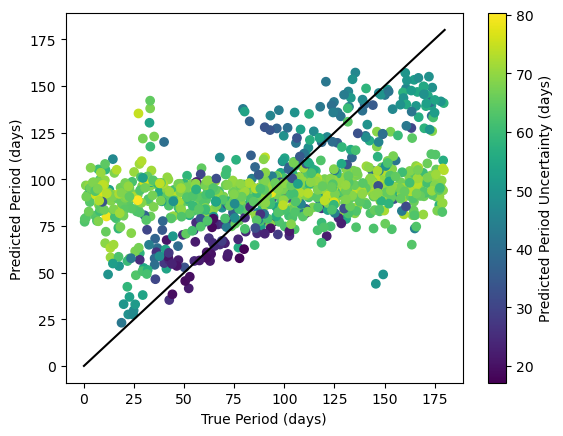

In [10]:
import matplotlib.pyplot as plt

%matplotlib inline

true_periods = trues*test_dataset.pmax
pred_periods = preds[:, 0]*test_dataset.pmax
pred_sigma = preds[:, 1]*test_dataset.pmax

plt.scatter(true_periods, pred_periods, c=pred_sigma)
plt.plot([0, 180], [0, 180], "k")
plt.xlabel("True Period (days)")
plt.ylabel("Predicted Period (days)")
plt.colorbar(label="Predicted Period Uncertainty (days)");

Most of the data are predicted to have the median period of 90 days, which is the best guess when the CNN doesn't know better. We also predicted the uncertainty in the period, so let's see what that looks like.

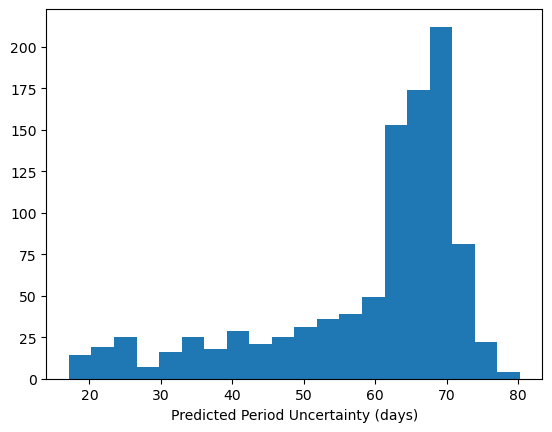

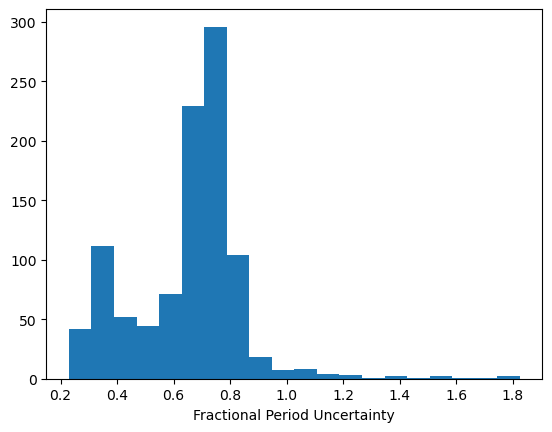

In [11]:
sigmas = preds[:, 1]*test_dataset.pmax
frac = sigmas/pred_periods

plt.figure()
plt.hist(sigmas, bins=20)
plt.xlabel("Predicted Period Uncertainty (days)")

plt.figure()
plt.hist(frac, bins=20)
plt.xlabel("Fractional Period Uncertainty");

There's a dip at sigma/period ~ 0.5, so let's use that to filter the results, weeding out "bad" predictions.

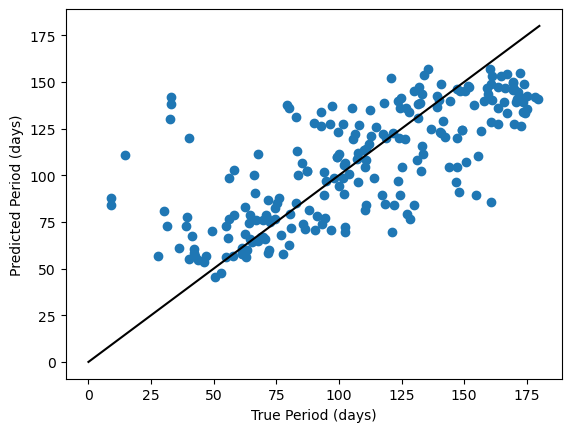

In [12]:
true_filtered = true_periods[frac < 0.5]
pred_filtered = pred_periods[frac < 0.5]
plt.scatter(true_filtered, pred_filtered)
plt.plot([0, 180], [0, 180], "k")
plt.xlabel("True Period (days)")
plt.ylabel("Predicted Period (days)");

With the "bad" predictions filtered out, the predictions look much better! Remember that the uncertainty is predicted from the quality of the data, so this kind of cut can be applied to predictions on real data as well. 

Finally, let's define an accuracy metric to measure the performance. For this example, we'll use the root-mean-squared (RMS) error.

In [13]:
def rms_error(true, pred):
    return np.sqrt(np.mean((true - pred)**2))

print(f"Unfiltered prediction count: {len(pred_periods)}\n"
      f"RMS error: {rms_error(true_periods, pred_periods):.2f} days\n\n"
      f"Filtered prediction count:   {len(pred_filtered)}\n"
      f"RMS error: {rms_error(true_filtered, pred_filtered):.2f} days.")

Unfiltered prediction count: 1000
RMS error: 46.04 days

Filtered prediction count:   221
RMS error: 29.13 days.


When the predictions are filtered, we retain only about 20% of the sample, but the accuracy improves significantly. Some takeaway notes:

- Filtering by predicted uncertainty improves the accuracy. This implies that the predicted uncertainty is a useful estimator of the true credibility of CNN predictions.
- While only 20% of the sample is left after filtering, remember that we only trained for 100 epochs, and on a subset of the training data. Doing a full run will improve both the accuracy of predictions *and* the number of "good" predictions.